# ML - Aprendizaje No Supervisado

## Clustering

El algoritmo de *K-Means* es uno de los más usados a la hora de aplicar *Clustering*, ya que es un método rápido y eficiente. Vamos a generar un conjunto de datos sintético para aprender a usar esta técnica.


Otras mejoras al algoritmo de *K-Means* incluyen: *K-Means* acelerados (usado por *Scikit-Learn* por defecto y que evita algunos cálculos de distancias) y *mini-batch K-Means* (que puedes usarse si el dataset es tan grande que no cabe en memoria). Vamos a ver un ejemplo de este último caso con el dataset kc_house_data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv('SolarPrediction.csv') # Cargamos el dataset

# Eliminamos las dos primera columnas que no aportan informacion
data = data.drop(['UNIXTime','Data','Time'], axis=1)

TimeSunRise = sorted(list(pd.unique(data['TimeSunRise'])))
TimeSunSet = sorted(list(pd.unique(data['TimeSunSet'])))

# para timeSunRise y timeSunSet, los clasificamos en categorias numericas para poder trabajar con ellos
# ya que usan horarios fijos de puesta y salida del sol podemos clasificarlos de forma unica y numerica meidante la funcion labelEncoder
data['TimeSunRise'] = LabelEncoder().fit_transform(data['TimeSunRise'])
data['TimeSunSet'] = LabelEncoder().fit_transform(data['TimeSunSet'])

from sklearn.model_selection import train_test_split 

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42) # Dividimos el dataset en entrenamiento y test

len(TimeSunRise), len(TimeSunSet) # tamaño de las categorias

(51, 56)

In [11]:
del data
# Eliminamos las variables que no necesitamos para liberar memoria
X_train

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
4152,680.04,57,30.45,68,26.70,4.50,3,43
13047,277.37,50,30.47,96,144.96,10.12,9,20
7420,1.29,47,30.48,56,119.52,3.37,16,7
6508,544.75,57,30.47,93,38.61,2.25,1,52
29110,1.22,41,30.23,103,177.55,2.25,43,4
...,...,...,...,...,...,...,...,...
29802,216.29,50,30.28,96,304.22,12.37,41,3
5390,1.47,44,30.37,100,162.80,3.37,2,48
860,1.20,48,30.42,64,158.90,4.50,5,32
15795,659.12,56,30.42,99,55.72,13.50,7,28


In [12]:
def featureNormalize(X):
    X_norm = X.copy()

    #creamos un array de ceros con una longitud igual al número de columnas en el array X. La variable mu y sigma se inicializa como este array de ceros.
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    #Creamos el promedio de cada filaa de X
    #media de cada columna
    mu = np.mean(X, axis = 0)

    #desviacion estandar de cada fila de X
    sigma = np.std(X, axis = 0)

    sigma[sigma == 0] = 1

    #normalizamos los datos con la siguiente formula
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [13]:
X_train, mu, sigma = featureNormalize(X_train) 

In [14]:
def load_next_batch(batch_size):
    indices = np.random.choice(len(X_train), batch_size, replace=False)
    return X_train.iloc[indices]

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26148 entries, 4152 to 23654
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Radiation               26148 non-null  float64
 1   Temperature             26148 non-null  float64
 2   Pressure                26148 non-null  float64
 3   Humidity                26148 non-null  float64
 4   WindDirection(Degrees)  26148 non-null  float64
 5   Speed                   26148 non-null  float64
 6   TimeSunRise             26148 non-null  float64
 7   TimeSunSet              26148 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [16]:
X_train.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
4152,1.493258,0.948718,0.496411,-0.269509,-1.404564,-0.501858,-1.137062,1.664008
13047,0.219325,-0.177808,0.861889,0.807721,0.020486,1.111185,-0.750338,0.248222
7420,-0.654113,-0.660605,1.044629,-0.731179,-0.286070,-0.826188,-0.299159,-0.552005
6508,1.065239,0.948718,0.861889,0.692303,-1.261047,-1.147649,-1.265971,2.218012
29110,-0.654334,-1.626199,-3.523853,1.077028,0.413200,-1.147649,1.441102,-0.736672


In [35]:
from sklearn.cluster import MiniBatchKMeans

k = 6
n_init = 10
n_iterations = 100
batch_size = 1000
init_size = 500
evaluate_on_last_n_iters = 10

best_kmeans = None # Definimos los parametros para el modelo de clustering

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size) # Instanciamos el modelo
    X_init = load_next_batch(init_size) # Cargamos los datos en lotes 
    minibatch_kmeans.partial_fit(X_init) # Ajustamos el modelo

    minibatch_kmeans.sum_inertia_ = 0 # Calculamos la inercia del modelo
    for iteration in range(n_iterations): # Ajustamos el modelo en cada iteracion
        X_batch = load_next_batch(batch_size) # Cargamos los datos en lotes
        minibatch_kmeans.partial_fit(X_batch) # Ajustamos el modelo
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_ # Calculamos la inercia del modelo

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans # Ajustamos el modelo de clustering

In [36]:
best_kmeans.score(X_train) # Obtenemos el score del modelo

-96044.87255160193

In [27]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=6, random_state=42)
y_pred = kmeans.fit_predict(X_train)
silhouette_avg = silhouette_score(X_train, y_pred) # Calculamos el score de silueta del modelo
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.24143715017149836


Número de clusters: 2, Puntaje de la silueta: 0.20779322934868436
Número de clusters: 3, Puntaje de la silueta: 0.2247112237311924
Número de clusters: 4, Puntaje de la silueta: 0.2285222580604433
Número de clusters: 5, Puntaje de la silueta: 0.2391228656982606
Número de clusters: 6, Puntaje de la silueta: 0.24143715017149836
Número de clusters: 7, Puntaje de la silueta: 0.2314839141314223
Número de clusters: 8, Puntaje de la silueta: 0.2251681818626876
Número de clusters: 9, Puntaje de la silueta: 0.22927310302833137
Número de clusters: 10, Puntaje de la silueta: 0.212195038341724
Número de clusters: 11, Puntaje de la silueta: 0.20397552366443578
Número de clusters: 12, Puntaje de la silueta: 0.1996268287513432
Número de clusters: 13, Puntaje de la silueta: 0.1931245874807155
Número de clusters: 14, Puntaje de la silueta: 0.19114704169238803


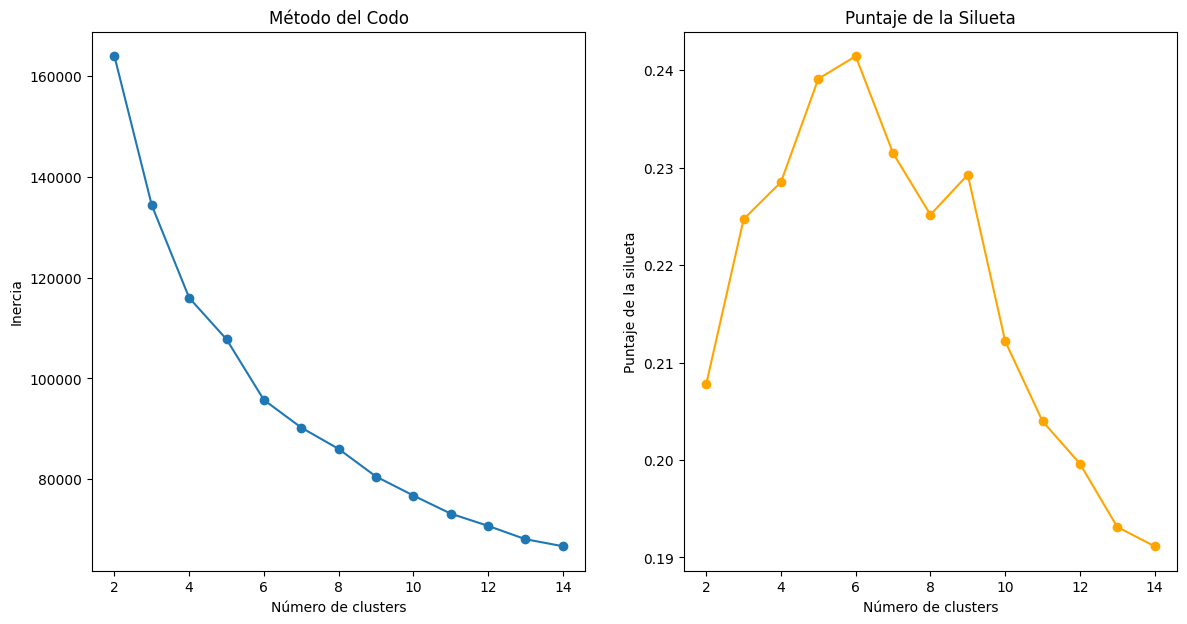

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Método del codo
inercias = []
silhouette_scores = []

for k in range(2,15):  # La silueta no se define para k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inercias.append(kmeans.inertia_)
    
    # Calcular el puntaje de la silueta y añadirlo a la lista
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'Número de clusters: {k}, Puntaje de la silueta: {score}')

# Gráfica del método del codo
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(range(1, 15), [np.nan] + inercias, marker='o')  # Agregar np.nan para el índice 0
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')

# Gráfica del puntaje de la silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), silhouette_scores, marker='o', color='orange')
plt.xlabel('Número de clusters')
plt.ylabel('Puntaje de la silueta')
plt.title('Puntaje de la Silueta')

plt.show()

Se puede observar que el valor optimo de clusters es 6 debido a que se observa un valor mas cercano a 1 en el silhouette_score

In [21]:
X_test, mu, sigma = featureNormalize(X_test)

In [22]:
def load_next_batch(batch_size):
    indices = np.random.choice(len(X_test), batch_size, replace=False)
    return X_test.iloc[indices]

In [28]:
from sklearn.cluster import MiniBatchKMeans

k = 6
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500
evaluate_on_last_n_iters = 10

best_kmeans = None # Definimos los parametros para el modelo de clustering

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size) # Instanciamos el modelo
    X_init = load_next_batch(init_size) # Cargamos los datos en lotes 
    minibatch_kmeans.partial_fit(X_init) # Ajustamos el modelo

    minibatch_kmeans.sum_inertia_ = 0 # Calculamos la inercia del modelo
    for iteration in range(n_iterations): # Ajustamos el modelo en cada iteracion
        X_batch = load_next_batch(batch_size) # Cargamos los datos en lotes
        minibatch_kmeans.partial_fit(X_batch) # Ajustamos el modelo
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_ # Calculamos la inercia del modelo

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans # Ajustamos el modelo de clustering

In [29]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=6, random_state=42)
y_pred_TEST = kmeans.fit_predict(X_test)
silhouette_avg = silhouette_score(X_test, y_pred_TEST) # Calculamos el score de silueta del modelo
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.23762862150500072


In [30]:
y_pred_TEST

array([5, 1, 4, ..., 4, 0, 1])